  # <h1><center>***FRENTE DE TODOS - PASO 2019***</center></h1>

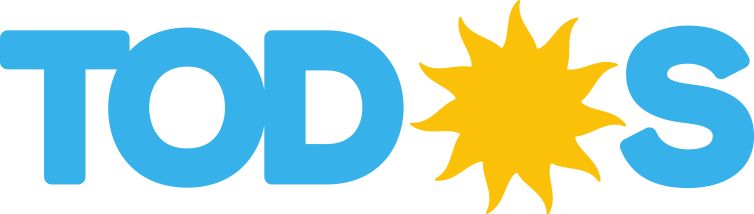



# **PREPARACION DE TABLAS**

In [28]:
#INSTALACION E IMPORTACION DE LIBRERIAS
%%capture
!pip install -- geopandas                                                
!pip install -- mapclassify  
!pip install -- contextily  
!pip install pygeos  
!pip install nbconvert
import contextily as ctx 
import urllib.request
import itertools
import os
import matplotlib.pyplot as plt
import sys
import geopandas as gpd
from zipfile import ZipFile
import pandas as pd
import numpy as np
import pygeos
import seaborn as sns

In [2]:
#CENSO Y ARCHIVOS SHAPE
%%capture
t_urls = [
'https://github.com/fbarone1988/fbarone/blob/master/censo1.zip?raw=true',       #Censo 2010 parte 1
'https://github.com/fbarone1988/fbarone/blob/master/censo2.zip?raw=true',       #Censo 2010 parte 2
'https://github.com/fbarone1988/fbarone/blob/master/censo3.zip?raw=true',       #Censo 2010 parte 3
                                                                
'https://github.com/fbarone1988/fbarone/blob/master/Codgeo_CABA_con_dato'
's.zip?raw=true',                                                               
'https://github.com/fbarone1988/fbarone/blob/master/CABA.zip?raw=true',
'https://github.com/fbarone1988/fbarone/blob/master/Ing_Fam_Cap_CABA.zip?raw=true'
]

t_archivos_zip = ['censo1.zip','censo2.zip','censo3.zip',                       #Lista con nombres de los archivos
'Codgeo_CABA_con_datos.zip','CABA.zip','Ing_Fam_Cap_CABA.zip']       
                                                                                #Descargo archivos
for (t_i, t_j) in itertools.zip_longest(t_urls, t_archivos_zip):
    urllib.request.urlretrieve(t_i,t_j) 

t_dir = os.listdir()                                                            #Lista con los archivos en el directorio local de Colab

for t_i in t_archivos_zip:                                                      #Check que el archivo se haya descargado al directorio local de Colab
  if t_i not in t_dir:    
    sys.exit('Atención: Faltan archivos para continuar')

for t_i in t_archivos_zip:
  t_unzip = t_i
  with ZipFile(t_unzip, 'r') as zip:                                            #Descomprime en modo lectura   
    zip.printdir()                                                              #Contenido del zip     
    zip.extractall()                                                            #Extracción de archivos

In [3]:
#TABLA SHAPE RADIOS CENSALES
RADIOS = gpd.read_file('cabaxrdatos.shp', header = 0, delim_whitespace=True )   #Creo tabla
RADIOS.rename(columns={'DEPTO':'COMUNA'},inplace=True)                          #Renombro columna                                 
RADIOS['COMUNA'] = RADIOS['COMUNA'].astype(int)                                 #Paso a int                 
RADIOS = RADIOS.reset_index()                                                   #Reseteo índice
RADIOS = RADIOS[["COMUNA","TOT_POB","geometry","LINK"]]                         #Me quedo con las columnas de interés
RADIOS = RADIOS.set_geometry('geometry')                                        #Establezco geometría

#MOMENTO ACÁ. ME INTERESA TOT_POB POR COMUNA
#SUBSETEARLO PARA HACER UN JOIN LIMPIO MÁS ADELANTE.
TOT_POB = RADIOS[["LINK","COMUNA","TOT_POB"]]                                   #Me quedo con las columnas de interés
TOT_POB = TOT_POB.groupby(['COMUNA']).agg({'TOT_POB':'sum'})                    #Agrupo por COMUNA
TOT_POB = TOT_POB.reset_index()                                                 #Resteo índice

In [4]:
#TABLAS DEL CENSO
t_Departamento = pd.read_csv('dpto.csv', delimiter=',')                         #Cargo tablas
t_Fraccion = pd.read_csv('frac.csv', delimiter=',')
t_Radio = pd.read_csv('radio.csv', delimiter=',')
t_Vivienda = pd.read_csv('vivienda.csv', delimiter=',')
t_Hogar = pd.read_csv('hogar.csv', delimiter=',')
t_Persona = pd.read_csv('persona.csv', delimiter=',')

t_D_F = t_Departamento.merge(t_Fraccion, on=['DPTO_REF_ID'], how='inner')       #Hago los joins
t_D_F_R = t_D_F.merge(t_Radio, on=['FRAC_REF_ID'], how='inner')
t_D_F_R_V = t_D_F_R.merge(t_Vivienda, on=['RADIO_REF_ID'], how='inner')
t_D_F_R_V_H = t_D_F_R_V.merge(t_Hogar, on=['VIVIENDA_REF_ID'], how='inner')

#*******************************************************************************
#MOMENTO ACÁ. ME INTERESA TOTPERS QUE ES UN COLUMNA DE TABLA HOGARES VAMOS A
#SUBSETEARLO PARA HACER UN JOIN LIMPIO MÁS ADELANTE.
#VER SI LO USAMOS POR AHORA USÉ TOT_POB

#POR RADIO CENSAL
TOTPERS = t_D_F_R_V_H[["RADIO_REF_ID", "TOTPERS"]]
TOTPERS = TOTPERS.reset_index()                                                 #Reseteo índice
TOTPERS.rename(columns={'RADIO_REF_ID':'RADIO' },inplace=True)                  #Renombro columnas 
TOTPERS = TOTPERS.groupby(['RADIO'])[['TOTPERS']].sum()                         #Agrupo para obtener el total de personas por radio censal
TOTPERS = TOTPERS.reset_index()                                                 #Reseteo índice (otra vez... evitemos problemas)
#POR COMUNA
COM_TOTPERS = t_D_F_R_V_H[["DPTO_REF_ID", "TOTPERS"]]
COM_TOTPERS = COM_TOTPERS.reset_index()                                         #Reseteo índices
COM_TOTPERS.rename(columns={'DPTO_REF_ID':'COMUNA' },inplace=True)              #Renombro columnas  
COM_TOTPERS = COM_TOTPERS.groupby(['COMUNA'])[['TOTPERS']].sum()                #Agrupo para obtener el total de personas por Comuna
COM_TOTPERS = COM_TOTPERS.reset_index()                                         #Reseteo índice (otra vez... evitemos problemas)
#*******************************************************************************
#BUENO AHORA SIGAMOS RECONSTRUYENDO EL CENSO.
CENSO = t_D_F_R_V_H.merge(t_Persona, on=['HOGAR_REF_ID'], how='inner')          #Último join para armar el censo
CENSO.rename(columns={'IDDPTO':'COMUNA','RADIO_REF_ID':'RADIO'},inplace=True)   #Renombro columna

#ARMO LA COLUMNA LINK
t_PROV = "02"                                                                   #CABA ES LA PROV "02"
CENSO['LINK'] = t_PROV                                                          #CREO LA COLUMNA LINK
CENSO['COM'] = CENSO['COMUNA'].astype(str)                                      #CREO COLUMNA STR DE COMUNA
CENSO['COM']= CENSO['COM'].str.zfill(3)                                         #LLENO CON 0 HASTA LLEGAR A LOS 3 DÍGITOS
CENSO['FRAC'] = CENSO['IDFRAC'].astype(str)                                     #CREO COLUMNA STR DE FRACCIÓN
CENSO['FRAC'] = CENSO['FRAC'].str.zfill(2)                                      #LLENO CON 0 HASTA LLEGAR A LOS 2 DÍGITOS
CENSO['RAD'] = CENSO['IDRADIO'].astype(str)                                     #CREO COLUMNA STR DE FRACCIÓN
CENSO['RAD'] = CENSO['RAD'].str.zfill(2)                                        #LLENO CON 0 HASTA LLEGAR A LOS 2 DÍGITOS
CENSO['LINK'] = CENSO['LINK'] + CENSO['COM'] + CENSO['FRAC'] + CENSO['RAD']     #CONCATENO

CENSO = CENSO[["COMUNA","LINK","TOTPERS","P09","P10","ALGUNBI","P03"]]          #Me quedo con las columnas de interés
CENSO.rename(columns={'P03':'EDAD'},inplace=True)                               #Renombro
CENSO = CENSO.reset_index()                                                     #Reseteo índice

#LIMPIEZA DE TEMPORALES
for temp in dir():                                                                                                                                                              
 if temp.startswith('t_'):
    del globals()[temp]
del temp


In [5]:
#TABLA SHAPE CIRCUITOS ELECTORALES
CIRCUITOS = gpd.read_file('CABA.shp')                                           #Creo tabla
CIRCUITOS.rename(columns={'circuito':'CIRCUITO', 'departamen':'COMUNA'},
inplace=True)                                                                   #Renombro columna
CIRCUITOS['COMUNA'] = CIRCUITOS['COMUNA'].str[6:9]                              #Substring a los últimos COMUNA
CIRCUITOS['COMUNA'] = CIRCUITOS['COMUNA'].astype(int)                           #Paso COMUNA a string
CIRCUITOS['CIRCUITO'] = CIRCUITOS['CIRCUITO'].astype(int)                       #Paso CIRCUITO a int
CIRCUITOS = CIRCUITOS[["COMUNA","CIRCUITO","geometry"]]                         #Me quedo con las columnas de interés
CIRCUITOS = CIRCUITOS.set_geometry('geometry')                                  #Establezco geometría

In [6]:
#TABLAS RESULTADOS ELECTORALES
#Carga del dataset                                                             
t_url = 'https://raw.githubusercontent.com/taodeying/MET4OP/master/dataset/'\
'elecciones_2019/resultados/120819-054029/datos_agrup.csv'
t_PASO_2019 = pd.read_csv(t_url)

#Chequeo de valores nulos en la data
t_Missing_t_PASO_2019 = t_PASO_2019.isnull().values.any()                                         
if t_Missing_t_PASO_2019 == True:
  sys.exit("Atención hay valores missing. Revisar datos.")

#Eliminacion de columnas y registros no relevantes al analisis
t_PASO_2019.drop(['CODIGO_DISTRITO'], axis = 1, inplace = True)                                  #Como analizamos solo CABA la columna CODIGO_DISTRITO no nos sirve ¡Adiós!
t_PASO_2019 = t_PASO_2019[t_PASO_2019['CODIGO_CATEGORIA'] == 100000000000]                       #Me quedo solo con la categoría Presidente y Vicepresidente
t_PASO_2019.loc[t_PASO_2019.CODIGO_CATEGORIA == 100000000000,'CODIGO_CATEGORIA'] = 1             #Reemplazo el código de la categoría por uno más legible

t_PASO_2019.drop(['NOMBRE_REGION'], axis = 1, inplace = True)                                    #Como vamos a usar CODIGO_SECCION, NOMBRE_REGION no nos sirve.

#Reformatea valores en columnas para hacerlos más legibles/trabajables

t_PASO_2019['CODIGO_SECCION'] = t_PASO_2019['CODIGO_SECCION'].astype(str)                        #Pasamos a string CODIGO_SECCION
t_PASO_2019['CODIGO_SECCION'] = t_PASO_2019['CODIGO_SECCION'].str[2:4]                           #Substring a los últimos 2 dígitos
t_PASO_2019['CODIGO_SECCION'] = t_PASO_2019['CODIGO_SECCION'].astype(int)                        #La volvemos a convertir a int

                                                                                                 #Repetimos con CODIGO_CIRCUITO
t_PASO_2019['CODIGO_CIRCUITO'] = t_PASO_2019['CODIGO_CIRCUITO'].astype(str)                      #Pasamos a string CODIGO_CIRCUITO
t_PASO_2019['CODIGO_CIRCUITO'] = t_PASO_2019['CODIGO_CIRCUITO'].str[-3:]                         #Substring a los últimos 3 dígitos
t_PASO_2019['CODIGO_CIRCUITO'] = t_PASO_2019['CODIGO_CIRCUITO'].astype(int)                      #La volvemos a convertir a int

                                                                                                 #Repetimos con CODIGO_MESA (Ya es una columna str)
t_PASO_2019['CODIGO_MESA'] = t_PASO_2019['CODIGO_MESA'].str[-5:-1]                               #Substring al número de mesa
t_PASO_2019['CODIGO_MESA'] = t_PASO_2019['CODIGO_MESA'].astype(int)                              #La convertimos en int

#En las PASO cuentan todos los votos válidos, eliminación de los demás.

t_No_cuentan = ['VII','VN','VR']                                                              
t_PASO_2019 = t_PASO_2019[t_PASO_2019['CODIGO_AGRUPACION'].isin(t_No_cuentan) == False]

#Limpieza de Categorias de Agrupaciones, la agrupación 0 pasará a ser el voto en blanco y las demás son abreviadas

t_Cero_t_PASO_2019 = t_PASO_2019[t_PASO_2019["CODIGO_AGRUPACION"] == "0"]                        #Me fijo que el CODIGO_AGRUPACION 0 se encuentre disponible
t_Contar = t_Cero_t_PASO_2019.CODIGO_AGRUPACION.count()                                      
if t_Contar >0:
  sys.exit("Ya hay una agrupación con código cero")

t_PASO_2019['CODIGO_AGRUPACION']= t_PASO_2019['CODIGO_AGRUPACION'].replace("VB","0")             #A los votos en blanco le ponto CODIGO_AGRUPACION 0
t_PASO_2019['CODIGO_AGRUPACION'] = t_PASO_2019['CODIGO_AGRUPACION'].astype(int)                  #Paso CODIGO_AGRUPACION a int
                                                                                                 #Acorto NOMBRE_CATEGORIA 
t_PASO_2019['NOMBRE_CATEGORIA']= t_PASO_2019['NOMBRE_CATEGORIA'].replace\
("Presidente y Vicepresidente de la República", "Presidente")                   

t_Agrupaciones = pd.unique(t_PASO_2019['NOMBRE_AGRUPACION'])                                     #Creo lista con todos los nombres de las agrupaciones 
t_PASO_2019['AGRUPACION'] = t_PASO_2019['NOMBRE_AGRUPACION']                                     #Duplico la columna NOMBRE_AGRUPACION para reemplazarla por nombres cortos
                                                                                                 #Creo lista de nombres cortos
t_Agrupaciones_Corto = ["MAS","NOS","FP","FIT","JxC","FdT","CF","PA","MAV",\
"Unite","Blanco"]                                                                                
t_Largo_1 = len(t_Agrupaciones)                                                                  #Cotejo que todas las agrupaciones tengan una abreviatura
t_Largo_2 = len(t_Agrupaciones_Corto)                                               
if t_Largo_1 != t_Largo_2:
  sys.exit("Revisar la longitud de las listas")

for t_i, t_j in itertools.zip_longest(t_Agrupaciones,t_Agrupaciones_Corto):                      #Loop que reemplaza AGRUPACION por sus abreviaturas
  t_PASO_2019['AGRUPACION']= t_PASO_2019['AGRUPACION'].replace(t_i,t_j)

#Cambio de nombre de columnas y limpieza de variables temporales
t_Renombrar = ['CODIGO_SECCION','CODIGO_CIRCUITO','CODIGO_MESA',\
'CODIGO_CATEGORIA','CODIGO_AGRUPACION','VOTOS_AGRUPACION',      \
'NOMBRE_CATEGORIA','NOMBRE_AGRUPACION']

t_Nuevos_Nombres = ['COMUNA','CIRCUITO','MESA','ID_CATEGORIA',  
'ID_AGRUPACION','VOTOS','CATEGORIA','AGRUPACION_LARGO']

for t_i, t_j in itertools.zip_longest(t_Renombrar,t_Nuevos_Nombres):                             #Loop que reemplaza los nombres de las columnas
  t_PASO_2019.rename(columns={ t_i : t_j}, inplace=True)

t_Rosetta = pd.read_csv('rosetta.csv')
t_Rosetta.rename(columns={ 'CODIGO_MESA_2019' : 'MESA', 'CODIGO_CIRCUITO_2017' : 
'CIRCUITO' }, inplace=True)

#Chequeo de valores nulos en la rosetta
t_Missing_t_Rosetta = t_Rosetta.isnull().values.any()                                         
if t_Missing_t_Rosetta == True:
  sys.exit("Atención hay valores missing. Revisar datos.")

t_Rosetta['MESA'] = t_Rosetta['MESA'].str[-5:-1]                                                 #Substring al número de mesa
t_Rosetta['MESA'] = t_Rosetta['MESA'].astype(int)                                                #Paso MESA a int
t_Rosetta['CIRCUITO'] = t_Rosetta['CIRCUITO'].astype(str)                                        #Paso CIRCUITO a string
t_Rosetta['CIRCUITO'] = t_Rosetta['CIRCUITO'].str[-3:]                                           #Substring a los últimos 3 dígitos
t_Rosetta['CIRCUITO'] = t_Rosetta['CIRCUITO'].astype(int)                                        #Paso CIRCUITO a int
t_PASO_2019 = t_PASO_2019.drop(columns=['CIRCUITO'])                                             #Drop CIRCUITO original Vamos a usar los circuitos de t_Rosetta
t_PASO_2019 = t_PASO_2019.merge(t_Rosetta, on="MESA", how="inner")                               #Join con Rosetta a través de las mesas

#RESULTADOS FRENTE DE TODOS POR COMUNA
t_PASO_2019_COMUNA= t_PASO_2019.groupby(['AGRUPACION','COMUNA'])[['VOTOS']].sum()                #Voto agrupado por COMUNA
                                                                                                 #Calculo porcentajes por COMUNA
t_PASO_2019_COMUNA['%_VOTOS'] = t_PASO_2019_COMUNA.groupby(['COMUNA'])['VOTOS'].\
transform(lambda x: round(x/x.sum()*100,2))                                                                  
t_PASO_2019_COMUNA = t_PASO_2019_COMUNA.reset_index()                                            #Reseteo índice
FdT_COMUNA = t_PASO_2019_COMUNA[t_PASO_2019_COMUNA['AGRUPACION'] == 'FdT']                       #Me quedo con el FdT

#RESULTADOS FRENTE DE TODOS POR CIRCUITO
t_PASO_2019_CIRCUITO = t_PASO_2019.groupby(['AGRUPACION','COMUNA','CIRCUITO'])[['VOTOS']].sum()  #Voto agrupado por CIRCUITO
                                                                                                 #Calculo porcentajes por CIRCUITO
t_PASO_2019_CIRCUITO['%_VOTOS'] = t_PASO_2019_CIRCUITO.groupby(['CIRCUITO'])\
['VOTOS'].transform(lambda x: round(x/x.sum()*100,2))
t_PASO_2019_CIRCUITO = t_PASO_2019_CIRCUITO.reset_index()                                        #Reseteo índice
FdT_CIRCUITO = t_PASO_2019_CIRCUITO[t_PASO_2019_CIRCUITO['AGRUPACION'] == 'FdT']                 #Me quedo con el FdT

#LIMPIEZA DE TEMPORALES
for temp in dir():                                                                                                                                                              
 if temp.startswith('t_'):
    del globals()[temp]
del temp

Text(0.5, 1.0, 'Personas con nivel universitario completo o superior (%)')

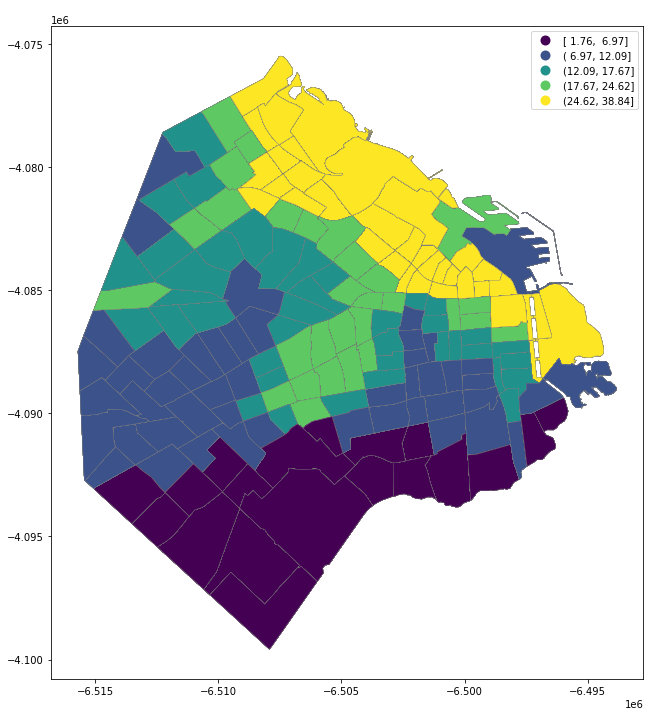

In [7]:
#*******************************************
#UNIVERSITARIO COMPLETO POR CIRCUITO
#*******************************************
#P09 == 7 ES UNIVERSITARIO, P10 == 1 ES QUE LO COMPLETÓ y P09 == 8 ES POSUNIVERSITARIO
CENSO_UNIV = CENSO
CENSO_UNIV['UNIV_COMPLETO'] = np.where(((CENSO_UNIV['P09'] == 7) & (CENSO_UNIV['P10'] == 1)) |                  #Identifico a los universitarios y los marco con un 1
(CENSO_UNIV['P09'] == 8), 1, 0)
CENSO_UNIV = CENSO_UNIV.groupby('LINK')[['UNIV_COMPLETO']].sum()                                                #Los agrupo por RADIO
CENSO_UNIV = CENSO_UNIV.reset_index()                                                                           #Reseteo índice
CENSO_UNIV = CENSO_UNIV.merge(RADIOS, on="LINK", how="inner")                                                   #Join con RADIOS
CENSO_UNIV = gpd.GeoDataFrame(CENSO_UNIV)                                                                       #Declaro como geo dataframe
CENSO_UNIV.set_geometry('geometry')                                                                             #Establezco geometría
CENSO_UNIV.to_crs(CIRCUITOS.crs, inplace=True)                                                                  #Acerco por centroide
CENSO_UNIV = gpd.sjoin(CENSO_UNIV, CIRCUITOS, how="right", op='intersects')                                     #Join espacial con los circuitos electorales
CENSO_UNIV['TOT_POB'] = CENSO_UNIV.groupby(['CIRCUITO'])['TOT_POB'].transform(lambda x: round(x.sum(),2))       #Calculo total población por circuito
CENSO_UNIV['UNIV_COMPLETO'] = CENSO_UNIV.groupby(['CIRCUITO'])['UNIV_COMPLETO'].transform(lambda x: x.sum())    #Calculo total UNIV_COMPLETO por circuito
CENSO_UNIV = CENSO_UNIV.reset_index()                                                                           #Reseteo índice
CENSO_UNIV['%_UNIV_COMPLETO'] = round((CENSO_UNIV['UNIV_COMPLETO']/CENSO_UNIV['TOT_POB'])*100,2)                #Calculo porcentje
CENSO_UNIV = CENSO_UNIV.reset_index()                                                                           #Reseteo índice

fig_CENSO_UNIV = CENSO_UNIV.plot(column='%_UNIV_COMPLETO',
                 scheme='fisher_jenks', 
                 figsize=(12, 12), 
                 legend=True,
                 edgecolor='gray',
                 linewidth = 0.3)
plt.title("Personas con nivel universitario completo o superior (%)", fontsize=18, color="white")

Text(0.5, 1.0, 'Personas con nivel universitario completo o superior (%)')

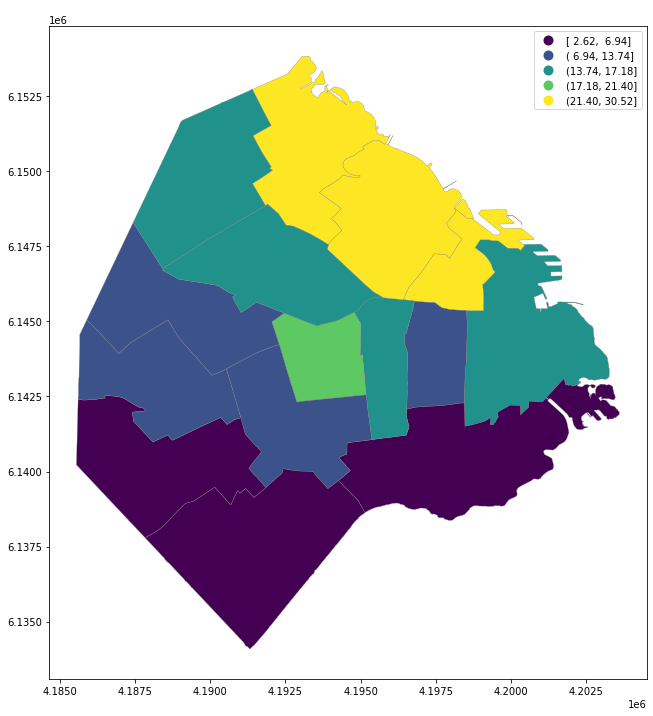

In [8]:
#*******************************************
#UNIVERSITARIO COMPLETO POR COMUNA
#*******************************************
#P09 == 7 ES UNIVERSITARIO, P10 == 1 ES QUE LO COMPLETÓ y P09 == 8 ES POSUNIVERSITARIO
CENSO['UNIV_COMPLETO'] = np.where(((CENSO['P09'] == 7) & (CENSO['P10'] == 1)) |                                 #Identifico a los universitarios y los marco con un 1
(CENSO['P09'] == 8), 1, 0)
COM_CENSO_UNIV = CENSO.groupby('COMUNA')[['UNIV_COMPLETO']].sum()                                               #Agrupo por COMUNA
COM_CENSO_UNIV = COM_CENSO_UNIV.reset_index()                                                                   #Reseteo índice
COM_CENSO_UNIV = COM_CENSO_UNIV.merge(RADIOS, on="COMUNA", how="inner")                                         #Join con RADIOS            
COM_CENSO_UNIV = COM_CENSO_UNIV.drop(['TOT_POB'], axis=1)                                                       #Drop TOT_POB por RADIO, voy a usar el por COMUNA
COM_CENSO_UNIV = COM_CENSO_UNIV.merge(TOT_POB, on ="COMUNA", how="inner")                                       #Join para incorporar el TOT_POB por COMUNA
#COM_CENSO_UNIV = COM_CENSO_UNIV.merge(COM_TOTPERS, on="COMUNA", how="inner")                                   #Solo es necesario si se usa TOTPERS
#COM_CENSO_UNIV['%_UNIV_COMPLETO'] = round((COM_CENSO_UNIV.UNIV_COMPLETO/(COM_CENSO_UNIV.TOTPERS))*100,2)       #Calculo el % de universitarios con TOTPERS
COM_CENSO_UNIV['%_UNIV_COMPLETO'] = round((COM_CENSO_UNIV.UNIV_COMPLETO/(COM_CENSO_UNIV.TOT_POB))*100,2)        #Calculo el % de universitarios
COM_CENSO_UNIV = COM_CENSO_UNIV[['COMUNA','UNIV_COMPLETO','TOT_POB','%_UNIV_COMPLETO','geometry']]              #Me quedo con las columnas de interés 
COM_CENSO_UNIV = gpd.GeoDataFrame(COM_CENSO_UNIV)                                                               #Declaro como GEO dataframe
COM_CENSO_UNIV = COM_CENSO_UNIV[['COMUNA','UNIV_COMPLETO','%_UNIV_COMPLETO','geometry']].dissolve(by='COMUNA')  #Nivel comuna
COM_CENSO_UNIV = COM_CENSO_UNIV.reset_index()                                                                   #Reseteo índice

COM_CENSO_UNIV.set_geometry('geometry')
fig_COM_CENSO_UNIV = COM_CENSO_UNIV.plot(column='%_UNIV_COMPLETO',
                 scheme='fisher_jenks', 
                 figsize=(12, 12), 
                 legend=True,
                 edgecolor='gray',
                 linewidth = 0.3)
plt.title("Personas con nivel universitario completo o superior (%)", fontsize=18, color="white") 

Text(0.5, 1.0, 'Personas con nivel primario incompleto mayores a 12 años (%)')

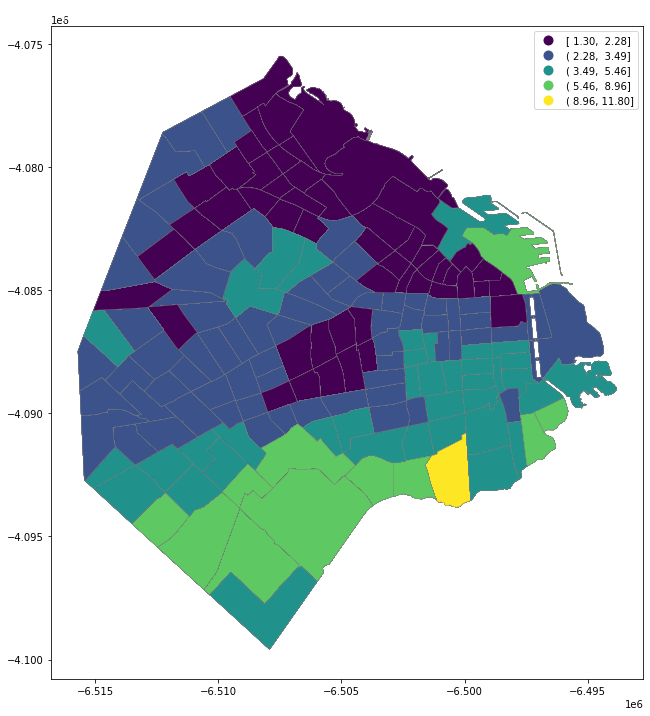

In [9]:
#*******************************************
#PRIMARIO INCOMPLETO POR CIRCUITO
#*******************************************
#P09 == 2 ES PRIMARIO, P09 == 3 ES EGB y P10 == 2 ES QUE NO LO COMPLETÓ

CENSO_PRIMINC = CENSO
#Identifico a los que no completaron la primaria y los marco con un 1 y son mayores de 12 años
CENSO_PRIMINC['PRIM_INCOMPLETO'] = np.where(((CENSO_PRIMINC['P09'] == 2) | (CENSO_PRIMINC['P09'] ==3))  
& (CENSO_PRIMINC['P10'] ==2) & (CENSO_PRIMINC['EDAD'] > 12),1,0)
CENSO_PRIMINC = CENSO_PRIMINC.groupby('LINK')[['PRIM_INCOMPLETO']].sum()                                                  #Los agrupo por RADIO
CENSO_PRIMINC = CENSO_PRIMINC.reset_index()                                                                               #Reseteo índice
CENSO_PRIMINC = CENSO_PRIMINC.merge(RADIOS, on="LINK", how="inner")                                                       #Join con RADIOS
CENSO_PRIMINC = gpd.GeoDataFrame(CENSO_PRIMINC)                                                                           #Declaro como geo dataframe
CENSO_PRIMINC.set_geometry('geometry')                                                                                    #Establezco geometría
CENSO_PRIMINC.to_crs(CIRCUITOS.crs, inplace=True)                                                                         #Acerco por centroide
CENSO_PRIMINC = gpd.sjoin(CENSO_PRIMINC, CIRCUITOS, how="right", op='intersects')                                         #Join espacial con los circuitos electorales
CENSO_PRIMINC['TOT_POB'] = CENSO_PRIMINC.groupby(['CIRCUITO'])['TOT_POB'].transform(lambda x: round(x.sum(),2))           #Calculo total población por circuito
CENSO_PRIMINC['PRIM_INCOMPLETO'] = CENSO_PRIMINC.groupby(['CIRCUITO'])['PRIM_INCOMPLETO'].transform(lambda x: x.sum())    #Calculo total PRIMINC por circuito
CENSO_PRIMINC = CENSO_PRIMINC.reset_index()                                                                               #Reseteo índice
CENSO_PRIMINC['%_PRIM_INCOMPLETO'] = round((CENSO_PRIMINC['PRIM_INCOMPLETO']/CENSO_PRIMINC['TOT_POB'])*100,2)             #Calculo porcentaje

fig_CENSO_PRIMINC = CENSO_PRIMINC.plot(column='%_PRIM_INCOMPLETO',
                    scheme='fisher_jenks', 
                    figsize=(12, 12), 
                    legend=True,
                    edgecolor='gray',
                    linewidth = 0.3)
plt.title("Personas con nivel primario incompleto mayores a 12 años (%)", fontsize=18, color="white")

Text(0.5, 1.0, 'Personas con nivel primario incompleto mayores a 12 años (%)')

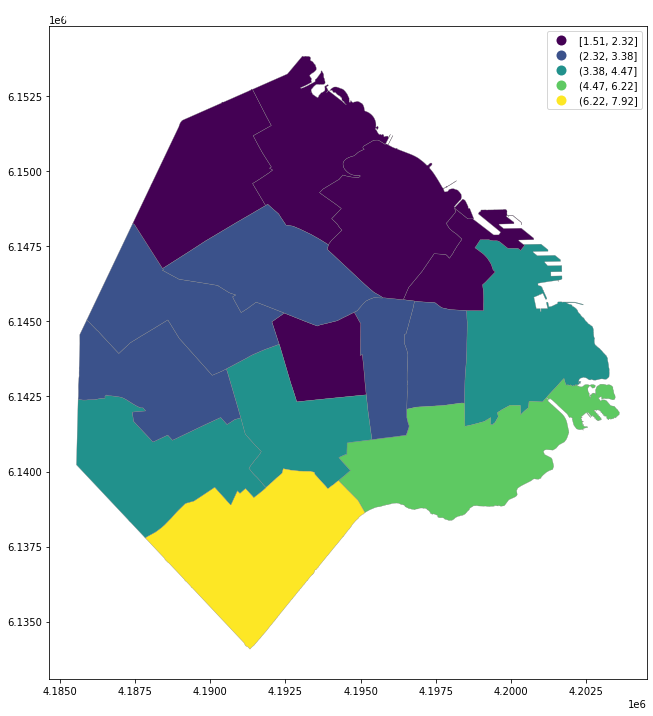

In [10]:
#*******************************************
#PRIMARIO INCOMPLETO POR COMUNA
#*******************************************
#P09 == 2 ES PRIMARIO, P09 == 3 ES EGB y P10 == 2 ES QUE NO LO COMPLETÓ

#Identifico a los que no completaron la primaria y son mayores de 12 años y los marco con un 1
CENSO['PRIM_INCOMPLETO'] = np.where(((CENSO['P09'] == 2) | (CENSO['P09'] ==3))  
& (CENSO['P10'] ==2) & (CENSO['EDAD'] > 12),1,0)

COM_CENSO_PRIMINC = CENSO.groupby(['COMUNA'])[['PRIM_INCOMPLETO']].sum()                                                 #Los agrupo por comuna
COM_CENSO_PRIMINC = COM_CENSO_PRIMINC.reset_index()                                                                      #Reseteo índice
COM_CENSO_PRIMINC = COM_CENSO_PRIMINC.merge(RADIOS, on="COMUNA", how="inner")                                            #Join con RADIOS            
COM_CENSO_PRIMINC = COM_CENSO_PRIMINC.drop(['TOT_POB'], axis=1)                                                          #Drop TOT_POB por RADIO, voy a usar el por COMUNA
COM_CENSO_PRIMINC = COM_CENSO_PRIMINC.merge(TOT_POB, on="COMUNA", how="inner")                                           #Join para incorporar el TOT_POB por COMUNA
#COM_CENSO_PRIMINC = COM_CENSO_PRIMINC.merge(COM_TOTPERS, on="COMUNA", how="inner")                                      #Solo es necesario si se usa TOTPERS
#COM_CENSO_PRIMINC['%_PRIM_INCOMPLETO'] = round((COM_CENSO_PRIMINC.PRIM_INCOMPLETO/(COM_CENSO_PRIMINC.TOTPERS))*100,2)   #Calculo el % de universitarios con TOTPERS
COM_CENSO_PRIMINC['%_PRIM_INCOMPLETO'] = round((COM_CENSO_PRIMINC.PRIM_INCOMPLETO/(COM_CENSO_PRIMINC.TOT_POB))*100,2)    #Calculo el % de universitarios con TOT_POB
COM_CENSO_PRIMINC = gpd.GeoDataFrame(COM_CENSO_PRIMINC)                                                                  #Declaro como GEO dataframe
COM_CENSO_PRIMINC = COM_CENSO_PRIMINC[['COMUNA','PRIM_INCOMPLETO','%_PRIM_INCOMPLETO','geometry']].dissolve(by='COMUNA') #Nivel comuna
COM_CENSO_PRIMINC = COM_CENSO_PRIMINC.reset_index()                                                                      #Reseteo índice

COM_CENSO_PRIMINC.set_geometry('geometry')
fig_COM_CENSO_PRIMINC = COM_CENSO_PRIMINC.plot(column='%_PRIM_INCOMPLETO',
                    scheme='fisher_jenks', 
                    figsize=(12, 12),
                    legend=True,
                    edgecolor='gray',
                    linewidth = 0.3)
plt.title("Personas con nivel primario incompleto mayores a 12 años (%)", fontsize=18, color="white")

Text(0.5, 1.0, 'Personas que viven en hogares con NBI (%)')

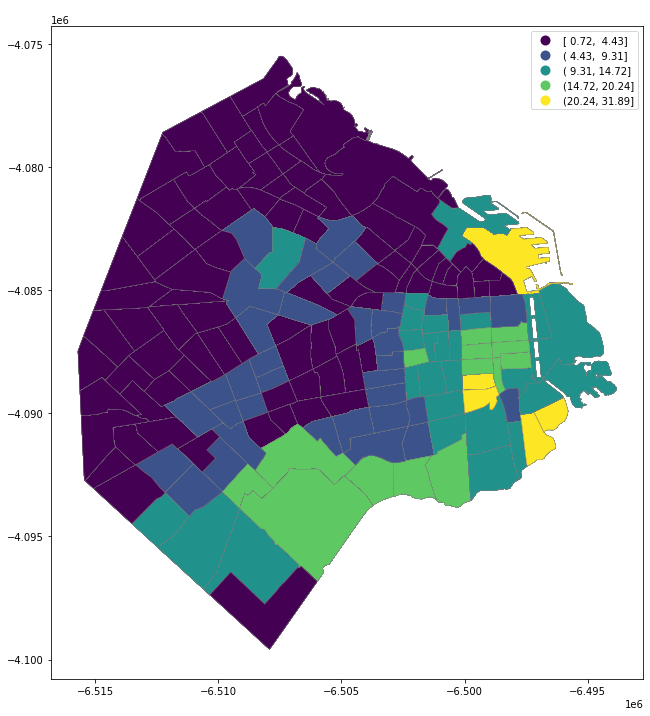

In [11]:
#*******************************************
#NBI POR CIRCUITO
#*******************************************
#Marco con los que tienen NBI (ALGUNBI 0 = NO, 1 = Sí, 2 = No aplica, 3 = Missing)
CENSO_NBI = CENSO
CENSO_NBI['NBI'] = np.where((CENSO_NBI['ALGUNBI'] == 1),1,0)                                               #Selecciono a los que tienen NBI
CENSO_NBI = CENSO_NBI.groupby('LINK')[['NBI']].sum()                                                       #Los agrupo por RADIO
CENSO_NBI = CENSO_NBI.reset_index()                                                                        #Reseteo índice
CENSO_NBI = CENSO_NBI.merge(RADIOS, on="LINK", how="inner")                                                #Join con RADIOS
CENSO_NBI = gpd.GeoDataFrame(CENSO_NBI)                                                                    #Declaro como geo dataframe
CENSO_NBI.set_geometry('geometry')                                                                         #Establezco geometría
CENSO_NBI.to_crs(CIRCUITOS.crs, inplace=True)                                                              #Acerco por centroide
CENSO_NBI = gpd.sjoin(CENSO_NBI, CIRCUITOS, how="right", op='intersects')                                  #Join espacial con los circuitos electorales 
CENSO_NBI['TOT_POB'] = CENSO_NBI.groupby(['CIRCUITO'])['TOT_POB'].transform(lambda x: round(x.sum(),2))    #Calculo total población por circuito
CENSO_NBI['NBI'] = CENSO_NBI.groupby(['CIRCUITO'])['NBI'].transform(lambda x: x.sum())                     #Calculo total NBI por circuito
CENSO_NBI = CENSO_NBI.reset_index()                                                                        #Reseteo índice
CENSO_NBI['%_NBI'] = round((CENSO_NBI['NBI']/CENSO_NBI['TOT_POB'])*100,2)                                  #Calculo porcentaje

fig_CENSO_NBI = CENSO_NBI.plot(column='%_NBI',
                    scheme='fisher_jenks', 
                    figsize=(12, 12), 
                    legend=True,
                    edgecolor='gray',
                    linewidth = 0.3)
plt.title("Personas que viven en hogares con NBI (%)", fontsize=18, color="white")

Text(0.5, 1.0, 'Personas que viven en hogares con NBI (%))')

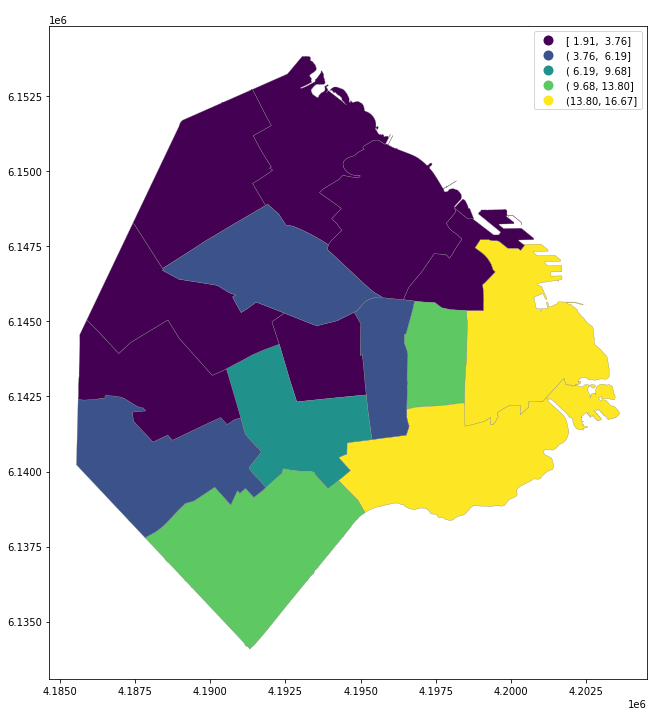

In [12]:
#*******************************************
#NBI POR COMUNA
#*******************************************
#Marco con los que tienen NBI (ALGUNBI 0 = NO, 1 = Sí, 2 = No aplica, 3 = Missing)
COM_CENSO_NBI = CENSO
COM_CENSO_NBI['NBI'] = np.where((COM_CENSO_NBI['ALGUNBI'] == 1),1,0)                     #Selecciono a los que tienen NBI
COM_CENSO_NB = COM_CENSO_NBI.dropna()                                                    #Elimino los missing 
COM_CENSO_NBI = CENSO.groupby(['COMUNA'])[['NBI']].sum()                                 #Los agrupo por comuna
COM_CENSO_NBI = COM_CENSO_NBI.reset_index()                                              #Reseteo índice
COM_CENSO_NBI = COM_CENSO_NBI.merge(RADIOS, on="COMUNA", how="inner")                    #Join con RADIOS            
COM_CENSO_NBI = COM_CENSO_NBI.drop(['TOT_POB'], axis=1)                                  #Drop TOT_POB por RADIO, voy a usar el por COMUNA
COM_CENSO_NBI = COM_CENSO_NBI.merge(TOT_POB, on="COMUNA", how="inner")                   #Join para incorporar el TOT_POB por COMUNA
#COM_CENSO_NBI = COM_CENSO_NBI.merge(COM_TOTPERS, on="COMUNA", how="inner")              #Solo es necesario si se usa TOTPERS
#COM_CENSO_NBI['%_NBI'] = round((COM_CENSO_NBI.NBI/(COM_CENSO_NBI.TOTPERS))*100,2)       #Calculo el % de NBI con TOTPERS
COM_CENSO_NBI['%_NBI'] = round((COM_CENSO_NBI.NBI/(COM_CENSO_NBI.TOT_POB))*100,2)        #Calculo el % de NBI con TOT_POB
COM_CENSO_NBI = gpd.GeoDataFrame(COM_CENSO_NBI)                                          #Declaro como GEO dataframe
COM_CENSO_NBI = COM_CENSO_NBI[['COMUNA','NBI','%_NBI','geometry']].dissolve(by='COMUNA') #Nivel comuna
COM_CENSO_NBI = COM_CENSO_NBI.reset_index()                                              #Reseteo índice

COM_CENSO_NBI.set_geometry('geometry')
fig_COM_CENSO_NBI = COM_CENSO_NBI.plot(column='%_NBI',
                    scheme='fisher_jenks', 
                    figsize=(12, 12),
                    legend=True,
                    edgecolor='gray',
                    linewidth = 0.3)
plt.title("Personas que viven en hogares con NBI (%))", fontsize=18, color="white")

Text(0.5, 1.0, 'Promedio de edad')

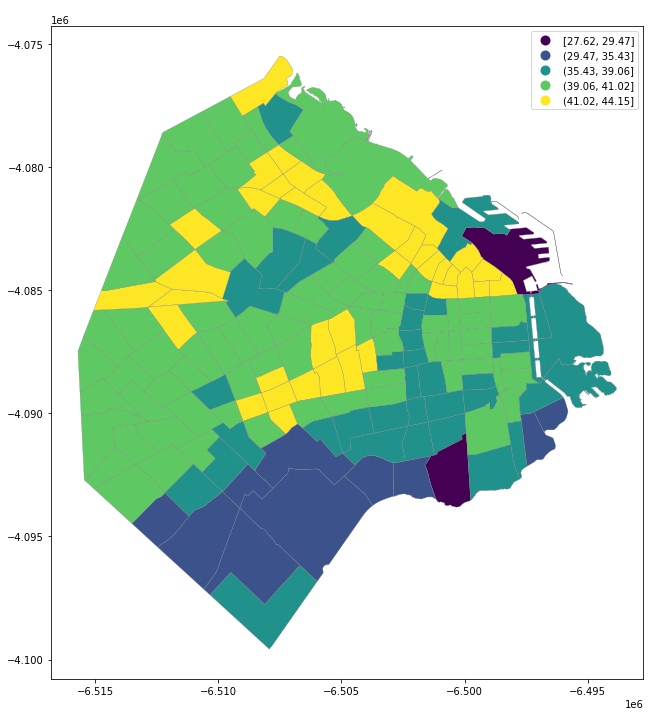

In [13]:
#**********************************************
#EDAD POR CIRCUITO 
#**********************************************
#Edad = P03 en el censo     
CENSO_EDAD = CENSO
CENSO_EDAD.rename(columns={'P03':'EDAD'},inplace=True)                                             #Renombro columna
CENSO_EDAD = CENSO_EDAD.dropna()                                                                   #Elimino los missing
CENSO_EDAD = CENSO_EDAD.groupby(["LINK"]).agg({'EDAD':'mean'})                                     #Media por radio
CENSO_EDAD = CENSO_EDAD.reset_index()                                                              #Reseteo índice
CENSO_EDAD = CENSO_EDAD.merge(RADIOS, on="LINK", how="inner")                                      #Join con RADIOS
CENSO_EDAD = gpd.GeoDataFrame(CENSO_EDAD)                                                          #Declaro como geo dataframe
CENSO_EDAD.set_geometry('geometry')                                                                #Establezco geometría
CENSO_EDAD.to_crs(CIRCUITOS.crs, inplace=True)                                                     #Acerco por centroide
CENSO_EDAD = gpd.sjoin(CENSO_EDAD, CIRCUITOS, how="right", op='intersects')                        #Join espacial con los circuitos electorales
CENSO_EDAD = CENSO_EDAD[['CIRCUITO','EDAD','geometry']].dissolve(by='CIRCUITO', aggfunc='mean')    #Nivel circuito
CENSO_EDAD = CENSO_EDAD.reset_index()                                                              #Reseteo índice

fig_CENSO_EDAD = CENSO_EDAD.plot(column='EDAD',
                scheme='fisher_jenks', 
                figsize=(12, 12), 
                legend=True,
                edgecolor='gray',
                linewidth = 0.3)
plt.title("Promedio de edad", fontsize=18, color="white")

Text(0.5, 1.0, 'Promedio de edad')

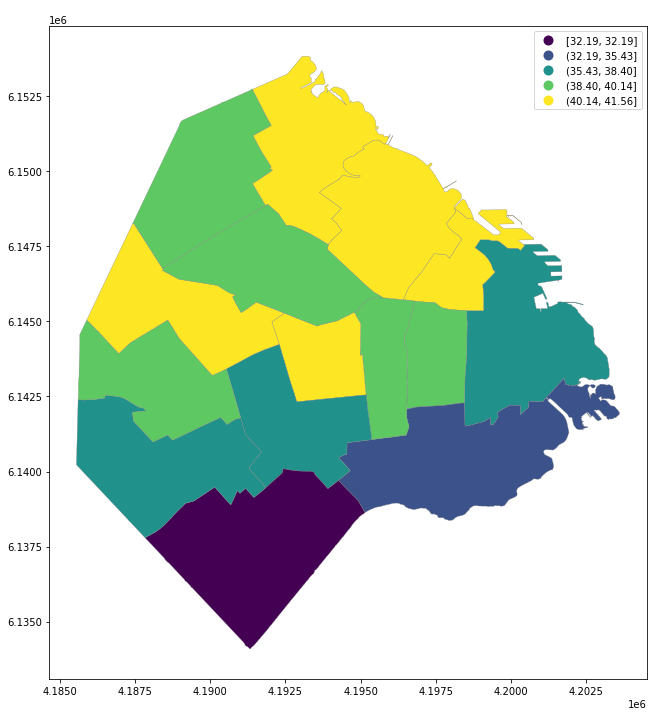

In [14]:
#**********************************************
#EDAD POR COMUNA 
#**********************************************
#Edad = P03 en el censo     
COM_CENSO_EDAD = CENSO
COM_CENSO_EDAD.rename(columns={'P03':'EDAD'},inplace=True)                                                #Renombro columna
COM_CENSO_EDAD = COM_CENSO_EDAD.dropna()                                                                  #Elimino los missing 
COM_CENSO_EDAD = COM_CENSO_EDAD.groupby(['COMUNA']).agg({'EDAD':'mean'})                                  #Media por radio
COM_CENSO_EDAD = COM_CENSO_EDAD.reset_index()                                                             #Reseteo índice
COM_CENSO_EDAD = COM_CENSO_EDAD.merge(RADIOS, on="COMUNA", how="inner")                                   #Join con RADIOS
COM_CENSO_EDAD = gpd.GeoDataFrame(COM_CENSO_EDAD)                                                         #Declaro como geo dataframe
COM_CENSO_EDAD.set_geometry('geometry')                                                                   #Establezco geometría
COM_CENSO_EDAD = COM_CENSO_EDAD[['COMUNA','EDAD','geometry']].dissolve(by='COMUNA', aggfunc='mean')       #Nivel circuito
COM_CENSO_EDAD = COM_CENSO_EDAD.reset_index()                                                             #Reseteo índice

fig_COM_CENSO_EDAD = COM_CENSO_EDAD.plot(column='EDAD',
                     scheme ='fisher_jenks', 
                     figsize=(12, 12), 
                     legend=True,
                     edgecolor='gray',
                     linewidth = 0.3)
plt.title("Promedio de edad", fontsize=18, color="white")

Text(0.5, 1.0, 'Votos al Frente de Todos (%) por Circuito')

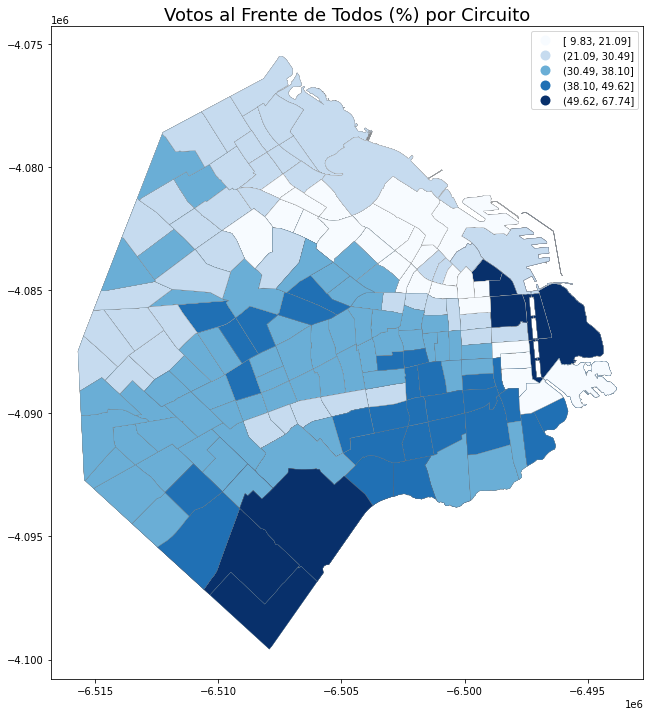

In [15]:
#*******************************************
#RESULTADOS FRENTE DE TODOS POR CIRCUITO
#*******************************************                                                                           
FdT_CIRCUITO_GEO = CIRCUITOS.merge(FdT_CIRCUITO, on="CIRCUITO", how="left")                #Join entre CIRCUITOS(shape) y los rdos. del FdT por circuito            
FdT_CIRCUITO_GEO.set_geometry('geometry')                                                  #Establezco geometría
FdT_CIRCUITO_GEO = gpd.sjoin(CIRCUITOS, FdT_CIRCUITO_GEO, how="left", op='intersects')     #Hago un join con los radios censales
FdT_CIRCUITO_GEO = FdT_CIRCUITO_GEO.reset_index()                                          #Reseteo índice

fig_FdT_CIRCUITO_RADIO_GEO = FdT_CIRCUITO_GEO .plot(column='%_VOTOS',
              scheme='fisher_jenks', 
              figsize=(12,12),
              legend=True,
              cmap = "Blues",
              edgecolor='gray',
              linewidth = 0.2)
plt.title("Votos al Frente de Todos (%) por Circuito", fontsize=18, color="Black")

Text(0.5, 1.0, 'Votos al Frente de Todos (%) por Comuna')

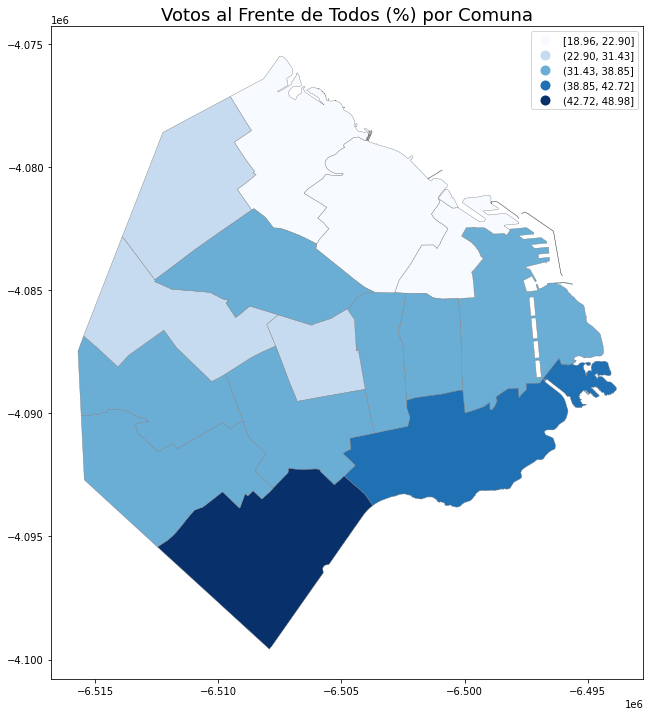

In [16]:
#*******************************************
#RESULTADOS FRENTE DE TODOS POR COMUNA
#*******************************************
FdT_COMUNA_GEO = CIRCUITOS.merge(FdT_CIRCUITO, on="CIRCUITO", how="inner")                                          #Hago un merge entre los resultados del FdT y el shape de CIRCUITO
FdT_COMUNA_GEO.drop(columns=['COMUNA_x'])                                                                           #Drop esta columuna porque no me sirve
FdT_COMUNA_GEO.rename(columns={'COMUNA_y':'COMUNA'},inplace=True)                                                   #Renombro
FdT_COMUNA_GEO = FdT_COMUNA_GEO.merge(FdT_COMUNA, on="COMUNA", how="inner")                                         #Hago merge para obtener los resultados por comuna
FdT_COMUNA_GEO = FdT_COMUNA_GEO[["AGRUPACION_x","VOTOS_y","COMUNA","%_VOTOS_y","geometry"]]                         #Me quedo con las columnas de interés
FdT_COMUNA_GEO.rename(columns={'AGRUPACION_x':'AGRUPACION','VOTOS_y':'VOTOS','%_VOTOS_y':'%_VOTOS'},inplace=True)   #Renombro
#Seteamos el detalle en comuna sin función de agregado (ya están hechos todos los cálculos)                
FdT_COMUNA_GEO = FdT_COMUNA_GEO[['COMUNA','AGRUPACION','VOTOS','%_VOTOS','geometry']].dissolve(by='COMUNA')        
FdT_COMUNA_GEO = FdT_COMUNA_GEO.reset_index()                                                                       #Reseteo índice

FdT_COMUNA_GEO.set_geometry('geometry') 
fig_FdT_COMUNA_GEO = FdT_COMUNA_GEO.plot(column='%_VOTOS',
              scheme='fisher_jenks', 
              figsize=(12,12),
              legend=True,
              cmap = "Blues",
              edgecolor='gray',
              linewidth = 0.4)
plt.title("Votos al Frente de Todos (%) por Comuna", fontsize=18, color="Black")

In [17]:
#Tabla FdT por Comuna limpia
COMUNA_FdT = FdT_COMUNA[["COMUNA","%_VOTOS"]]                                                         #Me quedo con las columnas de interés
COMUNA_FdT = COMUNA_FdT.round({'%_VOTOS': 1})                                                         #Redondeo

#Tabla universitarios y votos por Comuna limpia
COMUNA_UNIV = COM_CENSO_UNIV[["COMUNA","%_UNIV_COMPLETO"]]                                            #Me quedo con las columnas de interés
COMUNA_UNIV = COMUNA_UNIV.merge(COMUNA_FdT, on=['COMUNA'], how='inner')                               #Merge con el FdT
COMUNA_UNIV = COMUNA_UNIV.round({'%_UNIV_COMPLETO': 1})                                               #Redondeo

#Tabla primario incompleto y votos por Comuna limpia
COMUNA_PRIMINC = COM_CENSO_PRIMINC[["COMUNA","%_PRIM_INCOMPLETO"]]                                    #Me quedo con las columnas de interés
COMUNA_PRIMINC = COMUNA_PRIMINC.merge(COMUNA_FdT, on=['COMUNA'], how='inner')                         #Merge con el FdT
COMUNA_PRIMINC = COMUNA_PRIMINC.round({'%_PRIM_INCOMPLETO': 1})                                       #Redondeo

#Tabla NBI y votos por Comuna limpia
COMUNA_NBI = COM_CENSO_NBI[["COMUNA","%_NBI"]]                                                        #Me quedo con las columnas de interés
COMUNA_NBI = COMUNA_NBI.merge(COMUNA_FdT, on=['COMUNA'], how='inner')                                 #Merge con el FdT
COMUNA_NBI = COMUNA_NBI.round({'%_NBI': 1})                                                           #Redondeo

#Tabla EDAD y votos por Comuna limpia
COMUNA_EDAD = COM_CENSO_EDAD[["COMUNA","EDAD"]]                                                       #Me quedo con las columnas de interés
COMUNA_EDAD = COMUNA_EDAD.merge(COMUNA_FdT, on=['COMUNA'], how='inner')                               #Merge con el FdT
COMUNA_EDAD = COMUNA_EDAD.round({'EDAD': 1})                                                          #Redondeo

#Tabla FULL por Comuna limplia
COMUNA_FULL = COMUNA_UNIV.merge(COMUNA_PRIMINC, on=['COMUNA'], how='inner')                           #Merge universitarios con primario incompleto
COMUNA_FULL = COMUNA_FULL.merge(COMUNA_NBI, on=['COMUNA'], how='inner')                               #Merge con NBI
COMUNA_FULL = COMUNA_FULL.merge(COMUNA_EDAD, on=['COMUNA'], how='inner')                              #Merge con edad
COMUNA_FULL.rename(columns={'%_VOTOS_y':'%_VOTOS'},inplace=True)                                      #Renombro
COMUNA_FULL = COMUNA_FULL[["COMUNA","%_UNIV_COMPLETO","%_PRIM_INCOMPLETO","%_NBI","EDAD","%_VOTOS"]]  #Me quedo con las columnas de interés
COMUNA_FULL = COMUNA_FULL.iloc[:, :-1]                                                                #Dropeo la última columna que está repetida
COMUNA_FULL

,COMUNA,%_UNIV_COMPLETO,%_PRIM_INCOMPLETO,%_NBI,EDAD,%_VOTOS
0,1,17.2,4.2,16.7,37.8,35.0
1,2,30.5,1.5,2.3,41.6,19.0
2,3,13.0,3.4,12.2,39.0,37.2
3,4,6.4,6.2,14.7,35.4,42.7
4,5,16.4,2.7,6.2,40.1,36.3
5,6,21.4,2.0,2.4,41.2,30.5
6,7,11.4,4.2,9.7,37.8,36.1
7,8,2.6,7.9,13.8,32.2,49.0
8,9,6.9,4.5,5.3,38.4,38.8
9,10,10.8,3.0,3.8,39.9,34.5


In [18]:
#Tabla FdT por Circuito limpia
CIRCUITO_FdT = FdT_CIRCUITO[["COMUNA","CIRCUITO","%_VOTOS"]]                                                         #Me quedo con las columnas de interés
CIRCUITO_FdT = CIRCUITO_FdT.round({'%_VOTOS': 1})                                                                    #Redondeo

#Tabla universitarios y votos por Circuito limpia
CIRCUITO_UNIV = CENSO_UNIV[["CIRCUITO","%_UNIV_COMPLETO"]]                                                           #Me quedo con las columnas de interés
CIRCUITO_UNIV = CIRCUITO_UNIV.groupby(['CIRCUITO']).mean()                                                           #Agrupo para el join
CIRCUITO_UNIV = CIRCUITO_UNIV.reset_index()                                                                          #Reseteo índice
CIRCUITO_UNIV = CIRCUITO_UNIV.merge(CIRCUITO_FdT, on=['CIRCUITO'], how='inner')                                      #Merge con el FdT
CIRCUITO_UNIV = CIRCUITO_UNIV.round({'%_UNIV_COMPLETO': 1})                                                          #Redondeo
CIRCUITO_UNIV = CIRCUITO_UNIV[["COMUNA","CIRCUITO","%_UNIV_COMPLETO","%_VOTOS"]]                                     #Ordeno columnas

#Tabla primario incompleto y votos por Circuito limpia
CIRCUITO_PRIMINC = CENSO_PRIMINC[["CIRCUITO","%_PRIM_INCOMPLETO"]]                                                   #Me quedo con las columnas de interés
CIRCUITO_PRIMINC = CIRCUITO_PRIMINC.groupby(['CIRCUITO']).mean()                                                     #Agrupo para el join
CIRCUITO_PRIMINC = CIRCUITO_PRIMINC.reset_index()                                                                    #Reseteo índice
CIRCUITO_PRIMINC = CIRCUITO_PRIMINC.merge(CIRCUITO_FdT, on=['CIRCUITO'], how='inner')                                #Merge con el FdT
CIRCUITO_PRIMINC = CIRCUITO_PRIMINC.round({"%_PRIM_INCOMPLETO": 1})                                                  #Redondeo
CIRCUITO_PRIMINC = CIRCUITO_PRIMINC[["COMUNA","CIRCUITO","%_PRIM_INCOMPLETO","%_VOTOS"]]                             #Ordeno columnas

#Tabla NBI y votos por Circuito limpia
CIRCUITO_NBI = CENSO_NBI[["CIRCUITO","%_NBI"]]                                                                       #Me quedo con las columnas de interés
CIRCUITO_NBI = CIRCUITO_NBI.groupby(['CIRCUITO']).mean()                                                             #Agrupo para el join
CIRCUITO_NBI = CIRCUITO_NBI.reset_index()                                                                            #Reseteo índice
CIRCUITO_NBI = CIRCUITO_NBI.merge(CIRCUITO_FdT, on=['CIRCUITO'], how='inner')                                        #Merge con el FdT
CIRCUITO_NBI = CIRCUITO_NBI.round({"%_NBI": 1})                                                                      #Redondeo
CIRCUITO_NBI = CIRCUITO_NBI[["COMUNA","CIRCUITO","%_NBI","%_VOTOS"]]                                                 #Ordeno columnas

#Tabla EDAD y votos por Circuito limpia
CIRCUITO_EDAD = CENSO_EDAD[["CIRCUITO","EDAD"]]                                                                      #Me quedo con las columnas de interés
CIRCUITO_EDAD = CIRCUITO_EDAD.groupby(['CIRCUITO']).mean()                                                           #Agrupo para el join
CIRCUITO_EDAD = CIRCUITO_EDAD.reset_index()                                                                          #Reseteo índice
CIRCUITO_EDAD = CIRCUITO_EDAD.merge(CIRCUITO_FdT, on=['CIRCUITO'], how='inner')                                      #Merge con el FdT
CIRCUITO_EDAD = CIRCUITO_EDAD.round({"EDAD": 1})                                                                     #Redondeo
CIRCUITO_EDAD = CIRCUITO_EDAD[["COMUNA","CIRCUITO","EDAD","%_VOTOS"]]                                                #Ordeno columnas

#Tabla FULL por Comuna limplia
CIRCUITO_FULL = CIRCUITO_UNIV.merge(CIRCUITO_PRIMINC, on=['CIRCUITO'], how='inner')                                 #Merge universitarios con primario incompleto
CIRCUITO_FULL = CIRCUITO_FULL.merge(CIRCUITO_NBI, on=['CIRCUITO'], how='inner')                                     #Merge con NBI
CIRCUITO_FULL = CIRCUITO_FULL.merge(CIRCUITO_EDAD, on=['CIRCUITO'], how='inner')                                    #Merge con edad
CIRCUITO_FULL.rename(columns={"COMUNA_x":"COMUNA","%_VOTOS_y":'%_VOTOS'},inplace=True)                              #Renombro
CIRCUITO_FULL = CIRCUITO_FULL[["COMUNA","CIRCUITO","%_UNIV_COMPLETO","%_PRIM_INCOMPLETO","%_NBI","EDAD","%_VOTOS"]] #Me quedo con la columna de interés
CIRCUITO_FULL = CIRCUITO_FULL.iloc[:, :-1]                                                                          #Dropeo la última columna que está repetida                                                                        #D
CIRCUITO_FULL = CIRCUITO_FULL.loc[:, ~CIRCUITO_FULL.columns.duplicated()]                                           #Me quedó COMUNA duplicada, la borro
CIRCUITO_FULL

,COMUNA,CIRCUITO,%_UNIV_COMPLETO,%_PRIM_INCOMPLETO,%_NBI,EDAD,%_VOTOS
0,1,1,13.6,3.9,12.2,40.2,42.4
1,1,2,15.4,3.6,15.7,39.5,43.7
2,1,3,25.6,2.8,10.4,38.0,14.4
3,1,4,27.4,2.9,10.0,36.5,13.2
4,1,5,9.9,8.1,27.4,27.6,67.7
...,...,...,...,...,...,...,...
162,15,163,13.1,3.8,8.9,38.3,43.3
163,15,164,13.4,3.8,9.7,38.5,39.2
164,15,165,15.8,2.9,5.4,39.4,34.6
165,15,166,13.8,2.9,1.6,40.6,37.5


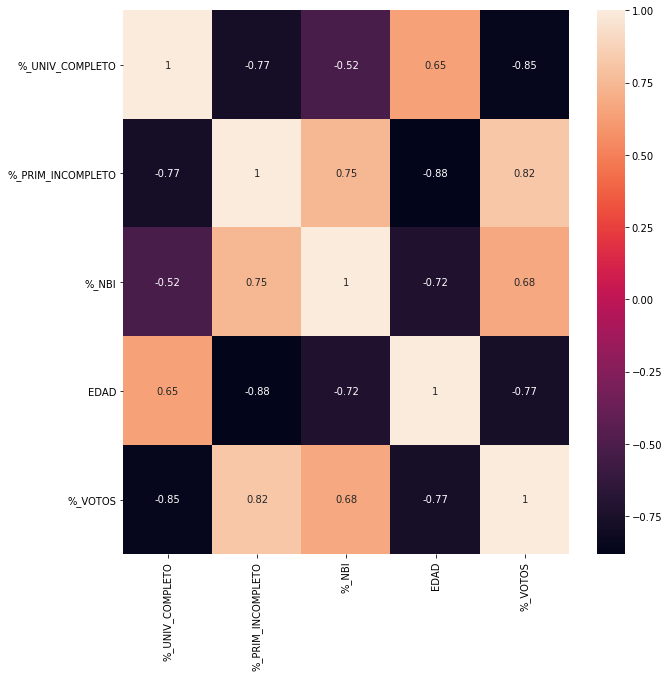

In [19]:
#Heatmap de correlación entre variables
CORREL_CIRCUITO_FULL = CIRCUITO_FULL.drop(['COMUNA', 'CIRCUITO'], axis=1)
corr = CORREL_CIRCUITO_FULL.corr() 
fig, ax = plt.subplots(figsize=(10,10))     
sns.heatmap(corr, annot = True) 

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


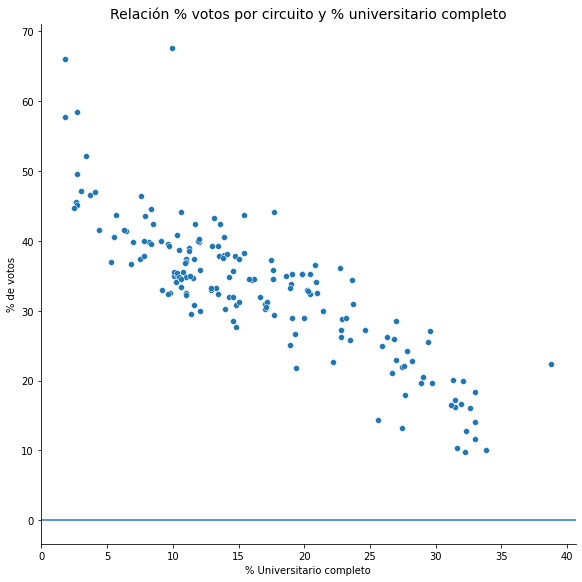

In [20]:
#Scatter de universitario 
rel_UNIV = sns.relplot("%_UNIV_COMPLETO","%_VOTOS", data=CIRCUITO_FULL, height=8, aspect=1/1)
plt.title("Relación % votos por circuito y % universitario completo", fontsize=14, color="black")
(rel_UNIV.map(plt.axhline)
  .set_axis_labels("% Universitario completo", "% de votos"))

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


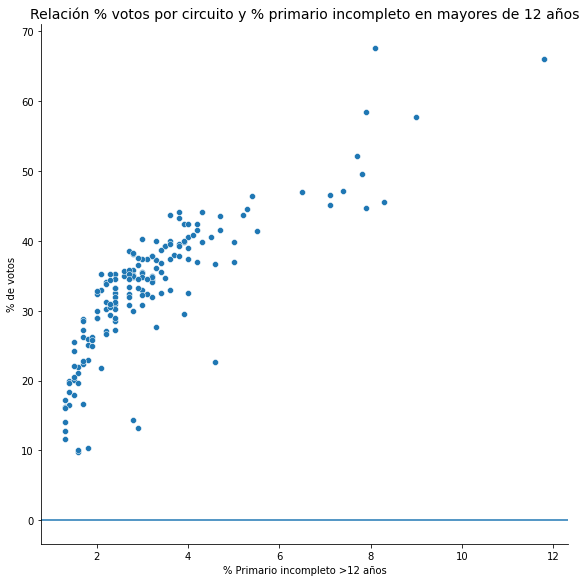

In [21]:
#Scatter de primario incompleto mayores de 12 años 
rel_PRIMINC = sns.relplot("%_PRIM_INCOMPLETO","%_VOTOS", data=CIRCUITO_FULL, height=8, aspect=1/1)
plt.title("Relación % votos por circuito y % primario incompleto en mayores de 12 años", fontsize=14, color="black")
(rel_PRIMINC.map(plt.axhline)
  .set_axis_labels("% Primario incompleto >12 años", "% de votos"))

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


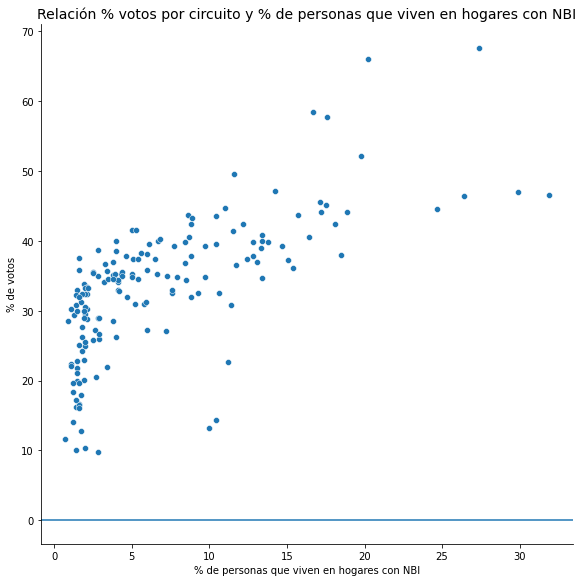

In [22]:
#Scatter de % personas que viven en hogares con NBI 
rel_PRIMINC = sns.relplot("%_NBI","%_VOTOS", data=CIRCUITO_FULL, height=8, aspect=1/1)
plt.title("Relación % votos por circuito y % de personas que viven en hogares con NBI", fontsize=14, color="black")
(rel_PRIMINC.map(plt.axhline)
  .set_axis_labels("% de personas que viven en hogares con NBI", "% de votos"))

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


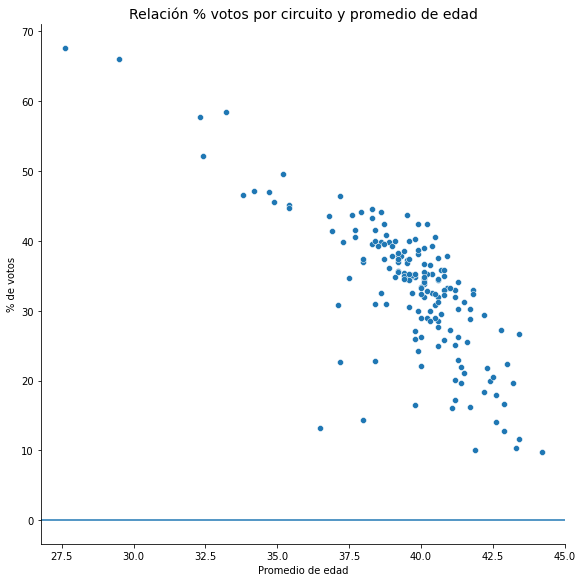

In [23]:
#Scatter de edad promedio
rel_PRIMINC = sns.relplot("EDAD","%_VOTOS", data=CIRCUITO_FULL, height=8, aspect=1/1)
plt.title("Relación % votos por circuito y promedio de edad", fontsize=14, color="black")
(rel_PRIMINC.map(plt.axhline)
  .set_axis_labels("Promedio de edad", "% de votos"))

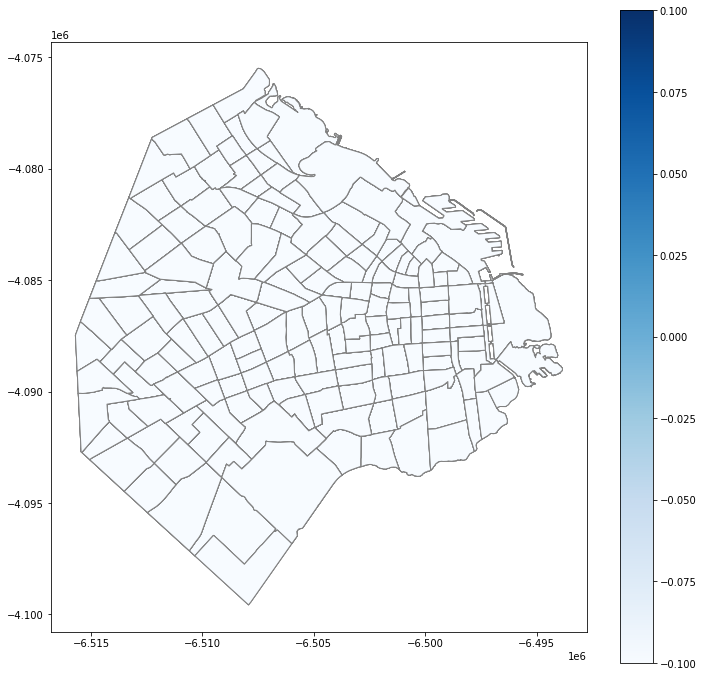

In [24]:
#*******************************************
#MAPA EN BLANCO PARA LA PRESENTACIÓN
#*******************************************                                                                           
FdT_CIRCUITO_GEO_BLANCO = CIRCUITOS.merge(FdT_CIRCUITO, on="CIRCUITO", how="left")                       #Join entre CIRCUITOS(shape) y los rdos. del FdT por circuito            
FdT_CIRCUITO_GEO_BLANCO.set_geometry('geometry')                                                         #Establezco geometría
FdT_CIRCUITO_GEO_BLANCO = gpd.sjoin(CIRCUITOS, FdT_CIRCUITO_GEO_BLANCO, how="left", op='intersects')     #Hago un join con los radios censales
FdT_CIRCUITO_GEO_BLANCO = FdT_CIRCUITO_GEO_BLANCO.reset_index()                                          #Reseteo índice
FdT_CIRCUITO_GEO_BLANCO['BLANCO'] = 0                                                                    #Creo columna con valor 0

fig_FdT_CIRCUITO_GEO_BLANCO = FdT_CIRCUITO_GEO_BLANCO.plot(column='BLANCO',
              k='1', 
              figsize=(12,12),
              legend=True,
              cmap = "Blues",
              edgecolor='gray',
              linewidth = 1)
    


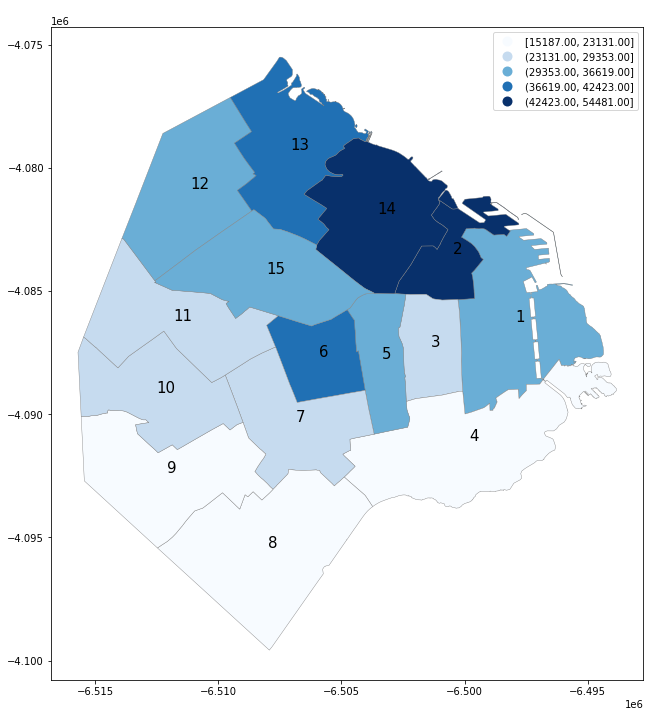

In [25]:
#**************************************************
#YAPA: Ingreso Familiar per capita por Comuna 2019
#**************************************************    

Ing_Fam_Cap_CABA =  pd.read_csv('Ing_Fam_Cap_CABA.csv', delimiter=',')                         #Cargo tablas
Ing_Fam_Cap_CABA.rename(columns={'Comuna':'COMUNA'},inplace=True)                              #Renombro columna 
Ing_Fam_Cap_CABA = FdT_COMUNA_GEO.merge(Ing_Fam_Cap_CABA, on="COMUNA", how="inner")            #Hago merge para obtener los resultados por comuna
Ing_Fam_Cap_CABA.set_geometry('geometry')                                                      #Establezco geometría

Ing_Fam_Cap_CABA["centro"] = Ing_Fam_Cap_CABA["geometry"].centroid                             #Creo columna centro con el centroide de la geometría
Ing_Fam_Cap_CABA_puntos = Ing_Fam_Cap_CABA.copy()                                              #Copio el dataframe
Ing_Fam_Cap_CABA_puntos.set_geometry("centro", inplace = True)                                 #Establezco la como geometría a lo que en el anterior dataframe eran los centroides

fig_Ing_Fam_Cap_CABA =  Ing_Fam_Cap_CABA.plot(column='Promedio IPCF',                          #Ploteo
              scheme='fisher_jenks', 
              figsize=(12,12),
              legend=True,
              cmap = "Blues",
              edgecolor='gray',
              linewidth = 0.4)

plt.title("Ingreso Promedio Familiar per cápita por Comuna 2019", 
          fontsize=18, color="White") 


Comuna_Nombre = []                                                                              #Creo una lista vacía
for x, y, label in itertools.zip_longest(Ing_Fam_Cap_CABA_puntos.geometry.x,                    #Itero coordenadas obteniendo el nro. de comuna
                                         Ing_Fam_Cap_CABA_puntos.geometry.y, 
                                         Ing_Fam_Cap_CABA_puntos["COMUNA"]):                    
    Comuna_Nombre.append(plt.text(x, y, label, fontsize = 15))                                  #Poblo la lista vacía con las comunas y las ploteo en sus respectivos centroides


# **REVISÉ HASTA ACÁ**

In [26]:
FDT = CIRCUITOS.merge(FdT_CIRCUITO, on="CIRCUITO", how="inner")
FDT.set_geometry('geometry')

,COMUNA_x,CIRCUITO,geometry,AGRUPACION,COMUNA_y,VOTOS,%_VOTOS
0,1,3,"POLYGON Z ((-6496304.252 -4084732.697 0.000, -...",FdT,1,253,14.45
1,4,45,"POLYGON Z ((-6501230.474 -4091702.182 0.000, -...",FdT,4,2313,43.68
2,3,37,"POLYGON Z ((-6501166.688 -4087904.826 0.000, -...",FdT,3,3270,40.00
3,1,18,"POLYGON Z ((-6498832.986 -4088373.028 0.000, -...",FdT,1,2172,44.54
4,13,141,"POLYGON Z ((-6503862.400 -4078547.361 0.000, -...",FdT,13,2465,22.09
...,...,...,...,...,...,...,...
162,13,135,"POLYGON Z ((-6507834.614 -4077215.626 0.000, -...",FdT,13,2146,22.85
163,14,149,"POLYGON Z ((-6503253.371 -4080723.227 0.000, -...",FdT,14,3157,16.49
164,9,101,"POLYGON Z ((-6515182.479 -4090061.116 0.000, -...",FdT,9,4649,35.03
165,10,102,"POLYGON Z ((-6514598.831 -4088679.114 0.000, -...",FdT,10,3197,30.76


In [27]:
COMBINADO_OK.set_geometry('geometry')
COMBINADO_OK_OK = COMBINADO_OK[['COMUNA','VOTOS','ALGUNBI','geometry']].dissolve(by='COMUNA', aggfunc='sum')
COMBINADO_OK_OK.plot(column='VOTOS', alpha=0.35, edgecolor='k',scheme='quantiles',figsize=(10, 10), legend=True) #MAPA DE VOTOS POR QUINTILES CON LOS RADIOS CENSALES

NameError: ignored

In [ ]:
FDT.to_crs(CENSO_UNIV.crs, inplace=True)
prueba_join_espacial = gpd.sjoin(FDT , CENSO_UNIV, how="left", op='intersects')

In [ ]:
prueba_join_espacial

In [ ]:
prueba_join_espacial.plot(column='%_VOTOS', alpha=0.35, edgecolor='k',scheme='quantiles',figsize=(10, 10), legend=True)

In [ ]:
prueba_join_espacial.plot(column='%_UNIV_COMPLETO', alpha=0.35, edgecolor='k',scheme='quantiles',figsize=(10, 10), legend=True)